# 高斯过程先验

理解高斯过程（GPs）对于模型构建和泛化的推理，以及在包括主动学习和深度学习中的超参数调整等多种应用中达到最先进性能非常重要。高斯过程无处不在，了解它们是什么以及如何使用它们符合我们的利益。

在本节中，我们介绍函数上的高斯过程_先验_。在下一个笔记本中，我们将展示如何使用这些先验进行_后验推断_并做出预测。下一节可以视为“高斯过程简述”，快速提供实际应用高斯过程中所需的知识。

In [1]:
import numpy as np
from scipy.spatial import distance_matrix
from d2l import torch as d2l

d2l.set_figsize()

## 定义

高斯过程被定义为_一组随机变量，其中任意有限数量的变量都具有联合高斯分布_。如果函数 $f(x)$ 是一个高斯过程，其_均值函数_为 $m(x)$，_协方差函数_或_核_为 $k(x,x')$，则表示为 $f(x) \sim \mathcal{GP}(m, k)$，那么在任何一组输入点 $x$（时间、空间位置、图像像素等）查询到的任何一组函数值都有一个均值向量为 $\mu$ 和协方差矩阵为 $K$ 的联合多元高斯分布：$f(x_1),\dots,f(x_n) \sim \mathcal{N}(\mu, K)$，其中 $\mu_i = E[f(x_i)] = m(x_i)$ 和 $K_{ij} = \textrm{Cov}(f(x_i),f(x_j)) = k(x_i,x_j)$。

这个定义可能看起来抽象且难以理解，但实际上高斯过程是非常简单的对象。任何形式为

$$f(x) = w^{\top} \phi(x) = \langle w, \phi(x) \rangle,$$ :eqlabel:`eq_gp-function`

的函数，其中 $w$ 从高斯（正态）分布中抽取，$\phi$ 为任意基函数向量，例如 $\phi(x) = (1, x, x^2, ..., x^d)^{\top}$，
都是一个高斯过程。此外，任何高斯过程 $f(x)$ 都可以表示成公式 :eqref:`eq_gp-function` 的形式。让我们考虑一些具体的例子，以开始熟悉高斯过程，之后我们就能体会到它们是多么简单和有用。

## 一个简单的高斯过程

假设 $f(x) = w_0 + w_1 x$，且 $w_0, w_1 \sim \mathcal{N}(0,1)$，其中 $w_0, w_1, x$ 都是一维的。我们可以将这个函数等价地写成内积的形式 $f(x) = (w_0, w_1)(1, x)^{\top}$。在上述 :eqref:`eq_gp-function` 中，$w = (w_0, w_1)^{\top}$ 且 $\phi(x) = (1,x)^{\top}$。

对于任何 $x$，$f(x)$ 是两个高斯随机变量之和。由于高斯分布在加法下是封闭的，因此对于任何 $x$ 来说，$f(x)$ 也是一个高斯随机变量。实际上，我们可以计算出对于任何特定的 $x$，$f(x)$ 是 $\mathcal{N}(0,1+x^2)$。同样地，对于任何一组输入 $x_1,\dots,x_n$，其对应的函数值 $(f(x_1),\dots,f(x_n))$ 的联合分布是一个多元高斯分布。因此 $f(x)$ 是一个高斯过程。

简而言之，$f(x)$ 是一个_随机函数_，或者说是_函数的分布_。通过反复对 $w_0, w_1$ 进行采样，并可视化相应的函数 $f(x)$，我们可以对该分布获得一些见解，这些函数是具有不同斜率和截距的直线，如下所示：

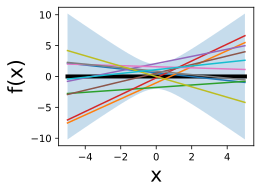

In [2]:
def lin_func(x, n_sample):
    preds = np.zeros((n_sample, x.shape[0]))
    for ii in range(n_sample):
        w = np.random.normal(0, 1, 2)
        y = w[0] + w[1] * x
        preds[ii, :] = y
    return preds

x_points = np.linspace(-5, 5, 50)
outs = lin_func(x_points, 10)
lw_bd = -2 * np.sqrt((1 + x_points ** 2))
up_bd = 2 * np.sqrt((1 + x_points ** 2))

d2l.plt.fill_between(x_points, lw_bd, up_bd, alpha=0.25)
d2l.plt.plot(x_points, np.zeros(len(x_points)), linewidth=4, color='black')
d2l.plt.plot(x_points, outs.T)
d2l.plt.xlabel("x", fontsize=20)
d2l.plt.ylabel("f(x)", fontsize=20)
d2l.plt.show()

如果$w_0$和$w_1$是从$\mathcal{N}(0,\alpha^2)$中抽取的，你认为改变$\alpha$会如何影响函数的分布？

## 从权重空间到函数空间

在上面的图中，我们看到了模型中的参数分布如何引起函数的分布。虽然我们通常对我们想要建模的函数有一些想法——无论它们是平滑的、周期性的、快速变化的等——但对参数进行推理通常是相当繁琐的，因为这些参数很大程度上是不可解释的。幸运的是，高斯过程提供了一种直接对函数进行推理的简单机制。由于高斯分布完全由其前两个矩（均值和协方差矩阵）定义，因此扩展来说，高斯过程由其均值函数和协方差函数定义。

在上述例子中，均值函数

$$m(x) = E[f(x)] = E[w_0 + w_1x] = E[w_0] + E[w_1]x = 0+0 = 0.$$

同样地，协方差函数为

$$k(x,x') = \textrm{Cov}(f(x),f(x')) = E[f(x)f(x')]-E[f(x)]E[f(x')] = E[w_0^2 + w_0w_1x' + w_1w_0x + w_1^2xx'] = 1 + xx'.$$

现在我们可以直接指定并从中抽样我们的函数分布，而无需从参数分布中抽样。例如，要从$f(x)$中抽样，我们只需形成与任何想要查询的$x$集合相关的多变量高斯分布，并直接从中抽样。我们将开始看到这种表述有多么有利。

首先，我们注意到对于上面简单的直线模型几乎相同的推导可以应用于找到任何形式为$f(x) = w^{\top} \phi(x)$的模型的均值和协方差函数，其中$w \sim \mathcal{N}(u,S)$。在这种情况下，均值函数$m(x) = u^{\top}\phi(x)$，协方差函数$k(x,x') = \phi(x)^{\top}S\phi(x')$。由于$\phi(x)$可以表示任何非线性基函数的向量，我们正在考虑一个非常一般的模型类别，包括甚至具有无限数量参数的模型。

## 径向基函数(RBF)核

_径向基函数_(RBF)核是最流行的高斯过程以及一般核机器的协方差函数。
该核的形式为$k_{\textrm{RBF}}(x,x') = a^2\exp\left(-\frac{1}{2\ell^2}||x-x'||^2\right)$，其中$a$是一个幅度参数，$\ell$是一个长度尺度超参数。

让我们从权重空间开始推导这个核。考虑函数

$$f(x) = \sum_{i=1}^J w_i \phi_i(x), w_i  \sim \mathcal{N}\left(0,\frac{\sigma^2}{J}\right), \phi_i(x) = \exp\left(-\frac{(x-c_i)^2}{2\ell^2 }\right).$$

$f(x)$是一系列宽度为$\ell$，中心位于点$c_i$处的径向基函数之和，如下面的图所示。


我们可以认出$f(x)$具有形式$w^{\top} \phi(x)$，其中$w = (w_1,\dots,w_J)^{\top}$且$\phi(x)$是包含每个径向基函数的向量。此高斯过程的协方差函数则为

$$k(x,x') = \frac{\sigma^2}{J} \sum_{i=1}^{J} \phi_i(x)\phi_i(x').$$

现在让我们考虑当我们把参数（和基函数）的数量推向无穷时会发生什么。设$c_J = \log J$, $c_1 = -\log J$, 且$c_{i+1}-c_{i} = \Delta c = 2\frac{\log J}{J}$, 当$J \to \infty$时。协方差函数变为黎曼和：

$$k(x,x') = \lim_{J \to \infty} \frac{\sigma^2}{J} \sum_{i=1}^{J} \phi_i(x)\phi_i(x') = \int_{c_0}^{c_\infty} \phi_c(x)\phi_c(x') dc.$$

通过设置$c_0 = -\infty$ 和 $c_\infty = \infty$，我们将无数个基函数分布在整条实线上，每
隔$\Delta c \to 0$距离：

$$k(x,x') = \int_{-\infty}^{\infty} \exp(-\frac{(x-c)^2}{2\ell^2}) \exp(-\frac{(x'-c)^2}{2\ell^2 }) dc = \sqrt{\pi}\ell \sigma^2 \exp(-\frac{(x-x')^2}{2(\sqrt{2} \ell)^2}) \propto k_{\textrm{RBF}}(x,x').$$

值得花时间来理解我们在这里做了什么。通过进入函数空间表示法，我们已经推导出了如何用有限的计算量来表示具有_无限_参数数量的模型。带有RBF核的高斯过程是一个_通用近似器_，能够以任意精度表示任何连续函数。从上面的推导中我们可以直观地看出原因。我们可以将每个径向基函数收缩成一个点质量，取$\ell \to 0$，并给每个点质量赋予我们希望的高度。

因此，带有RBF核的高斯过程是一个具有无限数量参数的模型，比任何有限神经网络都更具灵活性。也许关于_过参数化_神经网络的所有讨论都是错位的。正如我们将看到的那样，带有RBF核的GPs不会过拟合，并且实际上在小数据集上提供了特别令人信服的泛化性能。此外，:cite:`zhang2021understanding`中的例子，如能够完美拟合带有随机标签的图像但在结构化问题上仍能很好地泛化的能力，(可以用高斯过程完美再现):cite:`wilson2020bayesian`。神经网络并没有我们想象的那么独特。

通过对函数上的分布直接抽样，我们可以进一步建立关于带有RBF核的高斯过程及其超参数（如长度尺度）的直觉。与之前一样，这涉及到一个简单的程序：

1. 选择我们想要查询GP的输入$x$点：$x_1,\dots,x_n$。
2. 计算$m(x_i)$, $i = 1,\dots,n$，以及$k(x_i,x_j)$对于$i,j = 1,\dots,n$，分别形成均值向量和协方差矩阵$\mu$和$K$，其中$(f(x_1),\dots,f(x_n)) \sim \mathcal{N}(\mu, K)$。
3. 从此多元高斯分布中抽样以获得样本函数值。
4. 再次抽样以可视化更多在这些点查询的样本函数。

我们在下图中说明了这一过程。

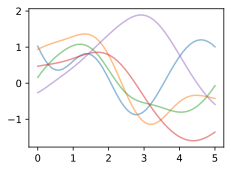

In [3]:
def rbfkernel(x1, x2, ls=4.):  #@save
    dist = distance_matrix(np.expand_dims(x1, 1), np.expand_dims(x2, 1))
    return np.exp(-(1. / ls / 2) * (dist ** 2))

x_points = np.linspace(0, 5, 50)
meanvec = np.zeros(len(x_points))
covmat = rbfkernel(x_points,x_points, 1)

prior_samples= np.random.multivariate_normal(meanvec, covmat, size=5);
d2l.plt.plot(x_points, prior_samples.T, alpha=0.5)
d2l.plt.show()

## 神经网络核

机器学习中关于高斯过程的研究是由神经网络研究引发的。Radford Neal 一直在追求越来越大的贝叶斯神经网络，最终在1994年（后来于1996年发表，因为这是最著名的NeurIPS拒稿之一）表明，具有无限隐藏单元的此类网络成为具有特定核函数的高斯过程 :cite:`neal1996bayesian`。对这一推导的兴趣再次浮现，像神经切线核这样的想法被用来研究神经网络的泛化属性 :cite:`matthews2018gaussian` :cite:`novak2018bayesian`。我们可以如下推导神经网络核。

考虑一个具有一层隐藏层的神经网络函数 $f(x)$：

$$f(x) = b + \sum_{i=1}^{J} v_i h(x; u_i).$$

$b$ 是偏置，$v_i$ 是隐藏层到输出层的权重，$h$ 是任何有界的隐藏单元传递函数，$u_i$ 是输入到隐藏层的权重，而 $J$ 是隐藏单元的数量。假设 $b$ 和 $v_i$ 相互独立，均值为零，方差分别为 $\sigma_b^2$ 和 $\sigma_v^2/J$，且 $u_i$ 具有独立同分布。然后我们可以使用中心极限定理来证明任何一组函数值 $f(x_1),\dots,f(x_n)$ 具有一个联合多元高斯分布。

对应高斯过程的均值和协方差函数是：

$$m(x) = E[f(x)] = 0$$

$$k(x,x') = \textrm{cov}[f(x),f(x')] = E[f(x)f(x')] = \sigma_b^2 + \frac{1}{J} \sum_{i=1}^{J} \sigma_v^2 E[h_i(x; u_i)h_i(x'; u_i)]$$

在某些情况下，我们实际上可以以封闭形式评估这个协方差函数。令 $h(x; u) = \textrm{erf}(u_0 + \sum_{j=1}^{P} u_j x_j)$，其中 $\textrm{erf}(z) = \frac{2}{\sqrt{\pi}} \int_{0}^{z} e^{-t^2} dt$，且 $u \sim \mathcal{N}(0,\Sigma)$。那么 $k(x,x') = \frac{2}{\pi} \textrm{sin}(\frac{2 \tilde{x}^{\top} \Sigma \tilde{x}'}{\sqrt{(1 + 2 \tilde{x}^{\top} \Sigma \tilde{x})(1 + 2 \tilde{x}'^{\top} \Sigma \tilde{x}')}})$。

RBF核是_平稳的_，意味着它是_平移不变的_，因此可以写成 $\tau = x-x'$ 的函数。直观上讲，平稳性意味着当我们移动输入空间时，函数的高级特性（如变化率）不会改变。然而，神经网络核是_非平稳的_。下面，我们展示了从带有此核的高斯过程中抽取的样本函数。我们可以看到，函数在原点附近看起来在质量上有所不同。

## 总结

进行贝叶斯推理的第一步涉及指定先验。高斯过程可用于指定整个函数的先验。从传统的“权重空间”建模视角开始，我们可以通过模型的功能形式并引入其参数的分布来诱导函数的先验。或者，我们也可以直接在函数空间中指定一个先验分布，其性质由一个核控制。函数空间方法有许多优点。我们可以构建实际上对应无限数量参数但只使用有限计算量的模型！此外，虽然这些模型具有很大的灵活性，但它们也对哪些类型的函数先验可能做出强烈的假设，从而导致在小数据集上相对良好的泛化。

函数空间模型中的假设通过核直观地控制，这些核通常编码了函数的高级特性，例如平滑性和周期性。许多核是平稳的，意味着它们是平移不变的。从具有平稳核的高斯过程中抽取的函数无论我们在输入空间中查看何处都大致具有相同的高级特性（例如变化率）。

高斯过程是一个相对通用的模型类，包含了许多我们已经熟悉的模型示例，包括多项式、傅里叶级数等，只要我们对参数有一个高斯先验。它们还包括即使没有参数上的高斯分布也具有无限数量参数的神经网络。这种联系由Radford Neal发现，促使机器学习研究人员从神经网络转向高斯过程。

## 练习

1. 从具有Ornstein-Uhlenbeck (OU) 核的GP中绘制样本先验函数，$k_{\textrm{OU}}(x,x') = \exp\left(-\frac{1}{2\ell}||x - x'|\right)$。如果你将长度尺度$\ell$固定为相同，这些函数与来自具有RBF核的GP的样本函数有何不同？

2. 改变RBF核的_振幅_$a^2$如何影响函数分布？

3. 假设我们形成$u(x) = f(x) + 2g(x)$，其中$f(x) \sim \mathcal{GP}(m_1,k_1)$和$g(x) \sim \mathcal{GP}(m_2,k_2)$。$u(x)$是否为高斯过程？如果是的话，它的均值和协方差函数是什么？

4. 假设我们形成$g(x) = a(x)f(x)$，其中$f(x) \sim \mathcal{GP}(0,k)$和$a(x) = x^2$。$g(x)$是否为高斯过程？如果是的话，它的均值和协方差函数是什么？$a(x)$的效果是什么？从$g(x)$中抽取的样本函数看起来像什么？

5. 假设我们形成$u(x) = f(x)g(x)$，其中$f(x) \sim \mathcal{GP}(m_1,k_1)$和$g(x) \sim \mathcal{GP}(m_2,k_2)$。$u(x)$是否为高斯过程？如果是的话，它的均值和协方差函数是什么？

[讨论](https://discuss.d2l.ai/t/12116)